# **Tarea Nº 4**
Scope: APIs

Curso:          Fundamentos de Programación en Python para Macroeconomía y Finanzas     
Profesor:       Victor Fuentes Campos     

- Fecha y hora de entrega: Viernes 12 de enero, 11:59pm
- Agregue los nombres de las personas con las que discutió esta tarea: ____ Armando Paredes ______
- Envíe su tarea haciendo el `push` de su código a su repo en GitHub Classroom: 

The Central Bank Reserve of Perú (BCRP) holds a list of datasets that are among the most comprehensive for macroeconomic purposes. In this exercise, we'll retrieve data from the [BCRP API](https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api) and explore the impact of pandemics

## Before starting

- You must pull the necessary data using `get` and `requests`
- You are required to apply the concepts learned in the previous sessions (`pandas`, `if`, `loop`, `function`)
- Hint: here is the BCRP url structure for the APIs call:
```html
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[códigos de series]/[formato de salida]/[periodo inicial]/[periodo final]/[idioma]
```

## The very long run

1. Locate the "Estadísticas de 100 años del BCRP" section in the BCRP´s series data statistics [here](https://estadisticas.bcrp.gob.pe/estadisticas/series/index) and identify the necessary code for the serie **`PBI (Mill S/ 2007)`**. Later, add manually the annual GDP values for 2022 and 2023 (be careful with the units of data). Then, **calculate** the Peruvian annual GDP growth (%) since 1922 to 2023. Finally, plot it using a very simple graph through `matplotlib` and provide critical insights (no more than 100 words)

    Hint1: use `.json()` for exploring the `content`. Your data is inside `["periods"]`
    
    Hint2: the graph must looks something like this: <img src="growth_gdp_long_run.png" max-width="300">
    

In [136]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.dates as mdates
from datetime import datetime
import statsmodels.api as sm
import numpy as np


In [137]:
# Solution
pbi_anual = requests.get("https://estadisticas.bcrp.gob.pe/estadisticas/series/anuales/resultados/PM04860AA/html")
url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/anuales/resultados/PM04860AA/html"
pbi_p = pd.read_html(url)

In [138]:
status_pbi = pbi_anual.status_code
status_pbi

200

In [165]:
#pbi_anual.text


In [166]:
pbi_values_22_23 = pbi_p[1].tail(7)
print(pbi_values_22_23)
print(type(pbi_values_22_23))

     Fecha  \
94    2016   
95    2017   
96    2018   
97    2019   
98    2020   
99    2021   
100   2022   

     Producto bruto interno y otros indicadores - PBI (millones S/ 2007)  
94                                              501581                    
95                                              514215                    
96                                              534665                    
97                                              546605                    
98                                              486402                    
99                                              552526                    
100                                             567340                    
<class 'pandas.core.frame.DataFrame'>


In [141]:
# let's obtain the annual GDP values for 2022 and 2023
pbi_2023 = pbi_values_22_23["Producto bruto interno y otros indicadores - PBI (millones S/ 2007)"]
print(pbi_2023)

94     501581
95     514215
96     534665
97     546605
98     486402
99     552526
100    567340
Name: Producto bruto interno y otros indicadores - PBI (millones S/ 2007), dtype: int64


In [142]:
pbi_total = pbi_p[1]
#print(pbi_total)

pbi_values_79_23 = pbi_p[1]["Producto bruto interno y otros indicadores - PBI (millones S/ 2007)"]
#print(pbi_values_79_23)
# let's calculate the gdp growth
previous_year_values = pbi_values_79_23.shift(1)
# print(previous_year_values)
# Calculate the percentage change
growth_rate = ((pbi_values_79_23 - previous_year_values) / previous_year_values) * 100
# Drop the first row (NaN after shifting)
growth_rate = growth_rate.dropna()
# Print the result
print(growth_rate)



1       5.831079
2       9.542744
3       2.437127
4       9.693748
5       2.255422
         ...    
96      3.976936
97      2.233174
98    -11.013986
99     13.594516
100     2.681141
Name: Producto bruto interno y otros indicadores - PBI (millones S/ 2007), Length: 100, dtype: float64


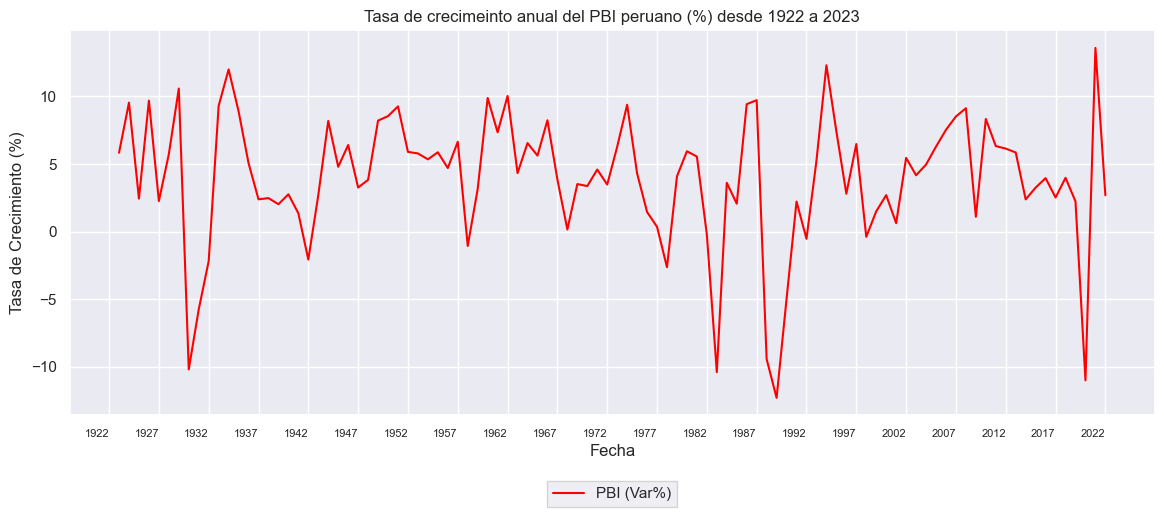

In [144]:
# Create a plot
plt.figure(figsize=(14, 5))
plt.plot(pbi_total.Fecha.iloc[1:], growth_rate, linestyle='-',color='red', label='PBI (Var%)')
plt.title('Tasa de crecimeinto anual del PBI peruano (%) desde 1922 a 2023')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Crecimiento (%)')
plt.grid(True)
# Especificar la ubicación y formato de las marcas en el eje x
plt.xticks(pbi_total.Fecha.iloc[0::5], rotation=0, ha="right", fontsize=8)
# Agregar leyenda
# Añadir leyenda debajo del eje x
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=False, shadow=False, ncol=1)
# Mostrar el gráfico
plt.show()

## The hitman

2. Retrieve the up-to-date data for the monthly GDP in index (2007=100) from this [link](https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/producto-bruto-interno-y-demanda-interna-variaciones-indice-2007). Then, calculate the the 5-year average monthly growth previous to the pandemics (ending in Feb-2020) for the 12-month rolling mean of the index, and project the alternative scenario of the Peruvian economy without the COVID-19. Then plot them out and provide insight from the gap between the real data and the pre-pandemic trend.

    Hint1: You may use the regression type of your election, but the OLS is recommended. 
    
    Hint2: Your plot should look somethig like this. You aren´t required to add flags/annotations/texts inside the graph <img src="growth_gdp_pandemics.png" max-width="300">

    Hint3: For more details about calculation, review this post from [The Economist](https://www.economist.com/graphic-detail/2021/10/28/americas-post-covid-economic-recovery-suffers-a-setback)
    


In [145]:
import pandas as pd
import requests 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json
from sklearn.linear_model import LinearRegression

In [146]:
# Extraer la data desde el API del BCRP

# URL de la API para la serie PN01770AM (PBI 2007 = 100) en json
url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PN01770AM/json/2015-2/2023-10"

# Realizar la solicitud GET
response = requests.get(url)

# Verificar si la solicitud fue exitosa
if response.status_code == 200:
    data = response.json()
else:
    print("Error en la solicitud:", response.status_code)
data

{'config': {'title': 'Producto bruto interno y demanda interna (índice 2007=100)',
  'series': [{'name': 'Producto bruto interno y demanda interna (índice 2007=100) - PBI',
    'dec': '1'}]},
 'periods': [{'name': 'Feb.2015', 'values': ['137.470299533785']},
  {'name': 'Mar.2015', 'values': ['148.339778409561']},
  {'name': 'Abr.2015', 'values': ['152.038604723334']},
  {'name': 'May.2015', 'values': ['150.15719220135']},
  {'name': 'Jun.2015', 'values': ['150.578546994917']},
  {'name': 'Jul.2015', 'values': ['153.252908823275']},
  {'name': 'Ago.2015', 'values': ['149.48186711913']},
  {'name': 'Sep.2015', 'values': ['151.999229212378']},
  {'name': 'Oct.2015', 'values': ['155.730120691974']},
  {'name': 'Nov.2015', 'values': ['153.424114847416']},
  {'name': 'Dic.2015', 'values': ['170.391576698868']},
  {'name': 'Ene.2016', 'values': ['143.100520938942']},
  {'name': 'Feb.2016', 'values': ['146.316293752734']},
  {'name': 'Mar.2016', 'values': ['153.620687314018']},
  {'name': 'Abr

In [147]:
# Convertir los datos a una cadena JSON
datos_json = json.dumps(data, indent=4)

# Ruta del archivo donde se guardará el JSON
ruta_archivo = 'data.json'

# Escribir la cadena JSON en un archivo
with open(ruta_archivo, 'w') as archivo:
    archivo.write(datos_json)

print(f"Archivo JSON '{ruta_archivo}' creado con éxito.")

Archivo JSON 'data.json' creado con éxito.


In [148]:
# Función para convertir JSON a DataFrame:

def convertir_json_a_dataframe(data_json):
    df = pd.DataFrame(data_json['periods'])
    df['name'] = df['name'].str.replace('.', '', regex=False)
    df['name'] = df['name'].replace({'Ene': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Abr': 'Apr', 'May': 'May', 'Jun': 'Jun',
                                     'Jul': 'Jul', 'Ago': 'Aug', 'Sep': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dic': 'Dec'}, regex=True)
    df['fecha'] = pd.to_datetime(df['name'], format='%b%Y')
    df['indice'] = pd.to_numeric(df['values'].str[0])
    df = df.set_index('fecha')
    return df

# Leer datos desde un archivo JSON
with open('data.json', 'r') as file:
    data_json = json.load(file)

# Convertir los datos JSON a DataFrame
df = convertir_json_a_dataframe(data_json)
print(df)

               name              values      indice
fecha                                              
2015-02-01  Feb2015  [137.470299533785]  137.470300
2015-03-01  Mar2015  [148.339778409561]  148.339778
2015-04-01  Apr2015  [152.038604723334]  152.038605
2015-05-01  May2015   [150.15719220135]  150.157192
2015-06-01  Jun2015  [150.578546994917]  150.578547
...             ...                 ...         ...
2023-06-01  Jun2023  [177.334725185052]  177.334725
2023-07-01  Jul2023  [175.480990031864]  175.480990
2023-08-01  Aug2023  [178.066865625777]  178.066866
2023-09-01  Sep2023  [179.973752609623]  179.973753
2023-10-01  Oct2023  [181.396080426984]  181.396080

[105 rows x 3 columns]


In [149]:
#df_seleccionado = df.loc[:, ['columna1', 'columna2']]
df = df.loc[:, ['indice']]
print(df)

                indice
fecha                 
2015-02-01  137.470300
2015-03-01  148.339778
2015-04-01  152.038605
2015-05-01  150.157192
2015-06-01  150.578547
...                ...
2023-06-01  177.334725
2023-07-01  175.480990
2023-08-01  178.066866
2023-09-01  179.973753
2023-10-01  181.396080

[105 rows x 1 columns]


In [150]:
# Calcular el promedio móvil de 12 meses
df['pbi_moving_avg'] = df['indice'].rolling(window=12).mean()
df.dropna(inplace=True)
df

,indice,pbi_moving_avg
fecha,,
2016-01-01,143.100521,151.330397
2016-02-01,146.316294,152.067563
2016-03-01,153.620687,152.507639
2016-04-01,156.272230,152.860441
2016-05-01,157.496837,153.472078
...,...,...
2023-06-01,177.334725,177.103408
2023-07-01,175.480990,176.926177
2023-08-01,178.066866,176.848477


In [151]:
# Normalizar los valores (Feb - 2020 = 100)
valor_feb_2020 = df.loc['2020-02-01', 'pbi_moving_avg']
df['pbi_moving_avg_normalized'] = (df['pbi_moving_avg'] / valor_feb_2020) * 100
df.dropna(inplace=True)
print(df)


                indice  pbi_moving_avg  pbi_moving_avg_normalized
fecha                                                            
2016-01-01  143.100521      151.330397                  87.976506
2016-02-01  146.316294      152.067563                  88.405060
2016-03-01  153.620687      152.507639                  88.660900
2016-04-01  156.272230      152.860441                  88.866003
2016-05-01  157.496837      153.472078                  89.221580
...                ...             ...                        ...
2023-06-01  177.334725      177.103408                 102.959745
2023-07-01  175.480990      176.926177                 102.856711
2023-08-01  178.066866      176.848477                 102.811539
2023-09-01  179.973753      176.651824                 102.697214
2023-10-01  181.396080      176.526213                 102.624190

[94 rows x 3 columns]


In [152]:
# Dividir los datos en entrenamiento y prueba
train = df[df.index < pd.to_datetime('2020-03-01')]
test = df[df.index >= pd.to_datetime('2020-02-01')]

print("Datos de entrenamiento")
print(train)
print("Datos de test")
print(test)

Datos de entrenamiento
                indice  pbi_moving_avg  pbi_moving_avg_normalized
fecha                                                            
2016-01-01  143.100521      151.330397                  87.976506
2016-02-01  146.316294      152.067563                  88.405060
2016-03-01  153.620687      152.507639                  88.660900
2016-04-01  156.272230      152.860441                  88.866003
2016-05-01  157.496837      153.472078                  89.221580
2016-06-01  155.977419      153.921984                  89.483135
2016-07-01  158.742284      154.379432                  89.749074
2016-08-01  158.111338      155.098554                  90.167138
2016-09-01  158.845788      155.669101                  90.498828
2016-10-01  159.111358      155.950871                  90.662636
2016-11-01  158.795139      156.398456                  90.922841
2016-12-01  176.279514      156.889117                  91.208089
2017-01-01  150.311211      157.490008               

In [153]:
# Preparar los datos para el modelo de regresión y Convertir las fechas a un formato numérico para el modelo
X_train = np.array(train.index.map(pd.Timestamp.toordinal)).reshape(-1, 1)
y_train = train['pbi_moving_avg_normalized']

In [154]:
# Modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los valores futuros
X_test = np.array(test.index.map(pd.Timestamp.toordinal)).reshape(-1, 1)
test['predictions'] = model.predict(X_test)

/var/folders/9d/2r5xh7sn3vs5d7bq30nnmk2r0000gn/T/ipykernel_13252/1143214142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = model.predict(X_test)


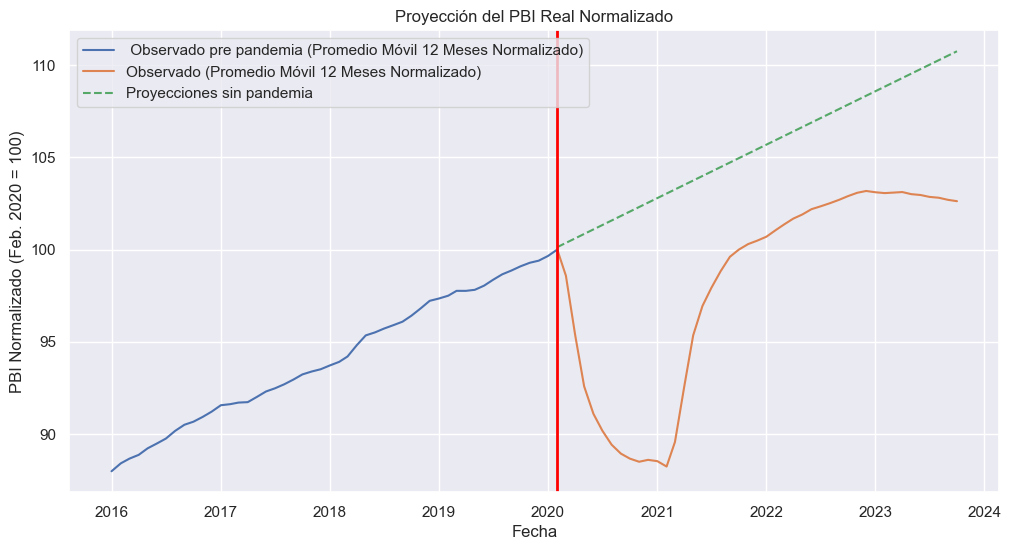

In [155]:
#Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['pbi_moving_avg_normalized'], label=' Observado pre pandemia (Promedio Móvil 12 Meses Normalizado)')
plt.plot(test.index, test['pbi_moving_avg_normalized'], label='Observado (Promedio Móvil 12 Meses Normalizado)')
plt.plot(test.index, test['predictions'], label='Proyecciones sin pandemia', linestyle='--')

plt.axvline(pd.to_datetime('2020-02-01'), color='red', linestyle='-', linewidth=2)
plt.grid(True)

plt.xlabel('Fecha')
plt.ylabel('PBI Normalizado (Feb. 2020 = 100)')
plt.title('Proyección del PBI Real Normalizado')
plt.legend()
plt.show()


## The winners

- Based on the [Nasdaq Stock Screener](https://www.nasdaq.com/market-activity/stocks/screener), identify the three largest companies in the three larger sectors defined by market cap
- Elaborate a list/dictionary/series (what ever you think is more suitable) containing all tickers (or symbols) and sectors from these companies.
- So far, you can download data from Nasdaq, web scrape it or copy it manually. It doesn´t matter
- Then, use `yfinance` library to retrieve the market data for all the 9 firms
- Construct a table with the most common *institucional holders* by sector. Is there any interesting pattern? Hint: loop the `institutional_holders` from `yfinance`
- Calculate the distribution of the daily percentage returns for the 3 larger companies (defined by market cap) along the last 5 years. Plot your results (feel free to find the most appealing way to represent them) and provide critical insights

$$
  percentage\_return_{t} = \frac{price_t-price_{t-1}}{price_t}*100+dividends (\%)
$$

- Hint1: you can find the `dividens` through the `yfinance`'s 
`Ticker()`
- Hint2: some firms may not be paying dividends

In [156]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import date, timedelta
import seaborn as sns

In [157]:
# Solution
# 3 sectores: tecnologia, consumidor discrecional y telecomunicaciones 

datos = {
    "Symbol": ["AAPL", "MSFT", "GOOG","AMZN","TSLA","COST","CSCO","TMUS","CMCSA"],
    "Sector": ["Technology","Technology","Technology","Consumer Discretionary","Consumer Discretionary","Consumer Discretionary","Telecommunications","Telecommunications","Telecommunications"]
}

Then, use `yfinance` library to retrieve the market data for all the 9 firms

In [159]:
# Extraer la lista de símbolos
symbols = datos["Symbol"]

# Crear un DataFrame vacío para almacenar los datos
all_data = pd.DataFrame()

for symbol in symbols:
    
    ticker = yf.Ticker(symbol)

    # Datos históricos del mercado para este ticker
    data = ticker.history(period="1y", interval="1d")

   
    data['Symbol'] = symbol

   
    all_data = pd.concat([all_data, data])


print(all_data.head(9))

                                 Open        High         Low       Close  \
Date                                                                        
2023-01-13 00:00:00-05:00  131.296104  134.170040  130.928166  134.010925   
2023-01-17 00:00:00-05:00  134.080541  136.526859  133.384435  135.184372   
2023-01-18 00:00:00-05:00  136.059502  137.839546  134.279443  134.458450   
2023-01-19 00:00:00-05:00  133.334724  135.492661  133.026450  134.518112   
2023-01-20 00:00:00-05:00  134.528068  137.252844  133.473962  137.103668   
2023-01-23 00:00:00-05:00  137.352267  142.523376  137.133489  140.325653   
2023-01-24 00:00:00-05:00  139.530086  142.364250  139.520147  141.737747   
2023-01-25 00:00:00-05:00  140.106863  141.638296  138.038423  141.071472   
2023-01-26 00:00:00-05:00  142.374203  143.448202  141.111258  143.159821   

                             Volume  Dividends  Stock Splits Symbol  
Date                                                                 
2023-01-13 0

Construct a table with the most common *institucional holders* by sector. Is there any interesting pattern? Hint: loop the `institutional_holders` from `yfinance`

In [160]:
tenedores_df_list = []  # Lista para almacenar los DataFrames individuales

for ticker, sector in zip(datos["Symbol"], datos["Sector"]):
    ticker_obj = yf.Ticker(ticker)
    tenedores = ticker_obj.institutional_holders

    if tenedores is not None:
        tenedores['Symbol'] = ticker
        tenedores['Sector'] = sector
        tenedores_df_list.append(tenedores)

# Concatena todos los DataFrames en la lista en uno solo
tenedores_df = pd.concat(tenedores_df_list, ignore_index=True)

print(tenedores_df.head())

  Date Reported                    Holder  pctHeld      Shares         Value  \
0    2023-06-30        Vanguard Group Inc   0.0834  1303688506  252876459508   
1    2023-06-30            Blackrock Inc.   0.0665  1039640859  201659137420   
2    2023-06-30   Berkshire Hathaway, Inc   0.0586   915560382  177591247296   
3    2023-06-30  State Street Corporation   0.0370   578897858  112288817516   
4    2023-06-30                  FMR, LLC   0.0196   307066638   59561715772   

  Symbol      Sector  
0   AAPL  Technology  
1   AAPL  Technology  
2   AAPL  Technology  
3   AAPL  Technology  
4   AAPL  Technology  


In [162]:
# Agrupar por sector y tenedor
agrupados = tenedores_df.groupby(['Sector', 'Holder']).size().reset_index(name='Count')

tenedores_comunes = agrupados.sort_values(['Sector', 'Count'], ascending=[True, False])

print(tenedores_comunes)

                    Sector                                      Holder  Count
2   Consumer Discretionary                              Blackrock Inc.      3
5   Consumer Discretionary                                    FMR, LLC      3
6   Consumer Discretionary               Geode Capital Management, LLC      3
8   Consumer Discretionary                              Morgan Stanley      3
9   Consumer Discretionary           Norges Bank Investment Management      3
12  Consumer Discretionary                    State Street Corporation      3
13  Consumer Discretionary                          Vanguard Group Inc      3
7   Consumer Discretionary                   JP Morgan Chase & Company      2
11  Consumer Discretionary               Price (T.Rowe) Associates Inc      2
0   Consumer Discretionary         Bank Of New York Mellon Corporation      1
1   Consumer Discretionary                 Bank of America Corporation      1
3   Consumer Discretionary           Capital Research Global Inv

In [163]:
symbols = ["AAPL", "MSFT", "GOOG"]

# Crear un DataFrame para almacenar los rendimientos
returns = pd.DataFrame()

for symbol in symbols:
    # Descargar datos históricos
    data = yf.download(symbol, start="2017-01-01", end="2022-01-01")
    

    daily_return = data['Close'].pct_change()
    
  
    returns[symbol] = daily_return


returns.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/patriciajacquelinemendozaarce/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/patriciajacquelinemendozaarce/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/patriciajacquelinemendozaarce/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


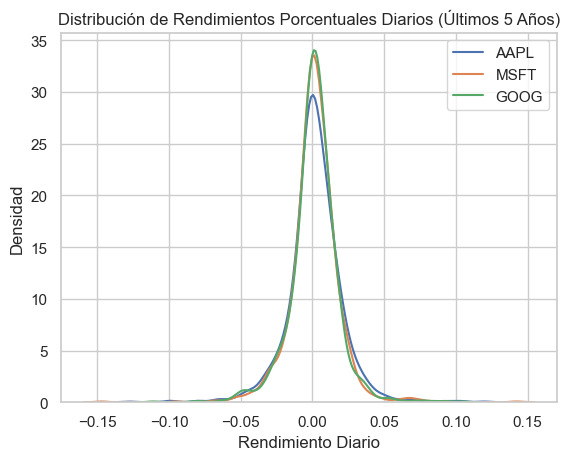

In [164]:
sns.set(style="whitegrid")

# Crear un gráfico de densidad para cada empresa
for symbol in symbols:
    sns.kdeplot(returns[symbol], label=symbol)

plt.title("Distribución de Rendimientos Porcentuales Diarios (Últimos 5 Años)")
plt.xlabel("Rendimiento Diario")
plt.ylabel("Densidad")
plt.legend()
plt.show()